In [1]:
import os
import argparse
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib . pyplot as plt


from scipy.integrate import odeint,solve_ivp
go_adjoint = True

!pip install torchdiffeq --quiet

if go_adjoint :
  from torchdiffeq import odeint_adjoint as odeint
else :
  from torchdiffeq import odeint

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# System (Lorenz)

In [2]:
class Lorenz(nn.Module):
  def __init__(self):
    super(Lorenz,self).__init__()
    self.sigma = nn.Parameter(torch.Tensor([10.0]))
    self.rho = nn.Parameter(torch.Tensor([28.0]))
    self.beta = nn.Parameter(torch.Tensor([8/3]))

  def forward(self, t, u):
    x,y,z = u[0], u[1], u[2]

    du1 = self.sigma[0] * (y-x)
    du2 = x * (self.rho[0] - z) - y
    du3 = x * y - self.beta[0] * z

    a = torch.stack([du1, du2, du3])
    return a

def F_Lorenz(t,x,sigma=10,b=8/3,r=28):
 F1 = sigma*(x[1]-x[0])
 F2 = r*x[0] - x[1] - x[0]*x[2]
 F3 = x[0]*x[1] - b*x[2]
 return np.array([F1,F2,F3])

# NODE

In [3]:
class ODEFunc(nn.Module):

  def __init__(self, u_dim=3, n_hidden=256):
    super(ODEFunc, self).__init__()
    self.net = nn.Sequential(
        nn.Linear(u_dim, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, u_dim)
    )

  def forward(self, t, u):
    return self.net(u)

#take the trajectory and use every point as an IVP, and try to predict the next one
def get_batch(traj):
  s = np.arange(len(traj)-1)
  batch_u0 = traj[s] #(M,D)
  batch_t = t[:2] #T
  batch_u = torch.stack([traj[s+i] for i in range(2)], dim=0) #(T,M,D)
  return batch_u0.to(device), batch_t.to(device), batch_u.to(device)

In [4]:
class RunningAverageMeter(object):
  def __init__(self,momentum=.99):
    self.momentum = momentum
    self.reset()

  def reset(self):
    self.val = None
    self.avg = 0

  def update(self, val):
    if self.val is None:
      self.avg = val
    else:
      self.avg = self.avg * self.momentum + val * (1- self.momentum) #linear combination!

    self.val = val

In [5]:
def visualize(y, y_hat, dt=0.1):
  predicted_time = max_predicted_time(y, y_hat,dt=dt)
  for dim in range(3):
      plt.figure(figsize=(10,3))
      plt.plot(t, y_hat[:,dim], color='C0', label='predicted')
      plt.plot(t, y[:,dim], color='C1', label='real')
      plt.plot(predicted_time*np.ones(2), [y_hat[:,dim].min(),y_hat[:,dim].max()],'k--', label="divergence time")

      plt.legend()
      plt.show()


  ax = plt.axes(projection='3d')
  ax.plot3D(y_hat[:,0], y_hat[:, 1], y_hat[:, 2],color="C0", label='predicted')
  ax.plot3D(y[:,0], y[:, 1], y[:, 2],color="C1", label='real')
  plt.show()

def max_predicted_time(y,y_obs,tol=4,dt=0.1):
  max_T = 0
  for max_T in range(y.shape[0]):
       if np.abs(y[max_T,:] - y_obs[max_T,:]).max() > tol:
        break
  return max_T*dt



# MAIN CODE:

In [33]:
#PARAMS
n_iters = 2500
test_freq = 50
METHOD = "rk4" #or "euler"

In [34]:
#generate the actual data:

dt = 0.02
T = 200
N = int(T/dt)
t = torch.linspace(0., T, N).to(device)

times = np.arange(0,T,dt)
sol = solve_ivp(F_Lorenz, [0,T], [1,1,1], t_eval=times)
X = sol.y

#90%
data_size = 800
split_indx = int(len(times)*0.9)
times_train = times[:split_indx]
X_train = X[:,:split_indx]
true_fU = torch.tensor(np.transpose(X_train[:,-data_size:]), dtype=torch.float).to(device)
t = torch.linspace(0, int(data_size*dt), data_size).to(device)

#10% for validation
times_val = torch.tensor(times[split_indx:]).to(device)
X_val = torch.tensor(np.transpose(X[:,split_indx:]), dtype=torch.float).to(device)

#train NODE:
ii = 0
func = ODEFunc().to(device)
optimizer = optim.Adam(func.parameters(), lr=10**-2)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

best_loss = 10**9

for itr in range(1, n_iters + 1):
  optimizer.zero_grad()
  batch_u0, batch_t, batch_u = get_batch(true_fU)
  pred_fU = odeint(func, batch_u0, batch_t, method=METHOD).to(device)

  loss = F.mse_loss(pred_fU, batch_u)
  loss.backward()
  optimizer.step()

  time_meter.update(time.time() - end)
  loss_meter.update(loss.item())

  if itr % test_freq == 0 or itr == 1:
    if itr > 1300:
      optimizer.param_groups[0]['lr'] = 10**-4
    with torch.no_grad():
      pred_fU = odeint(func, true_fU[0], t, method=METHOD)
      loss = F.mse_loss(pred_fU, true_fU)

      if loss < best_loss:
        torch.save(func, 'best_NODE.pt')
        best_loss = loss
      #plot:
      visualize(true_fU, pred_fU,dt=dt)

  print('Iter {:04d} | Total Loss {:.6f}'.format(itr , loss.item()))
  ii += 1

Output hidden; open in https://colab.research.google.com to view.

In [13]:
from google.colab import drive

drive.mount('/content/drive')
X_res = np.load('/content/drive/MyDrive/AdvancedNN/Project/reservoir_lorenz.npy')
X_res = np.transpose(X_res)

import seaborn as sns
sns.set_theme("poster")

func = torch.load("/content/drive/MyDrive/AdvancedNN/Project/node_lorenz.pt")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-35-9091dd9b2e74>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float)


NODE max time:2.92
RES. max time:7.5


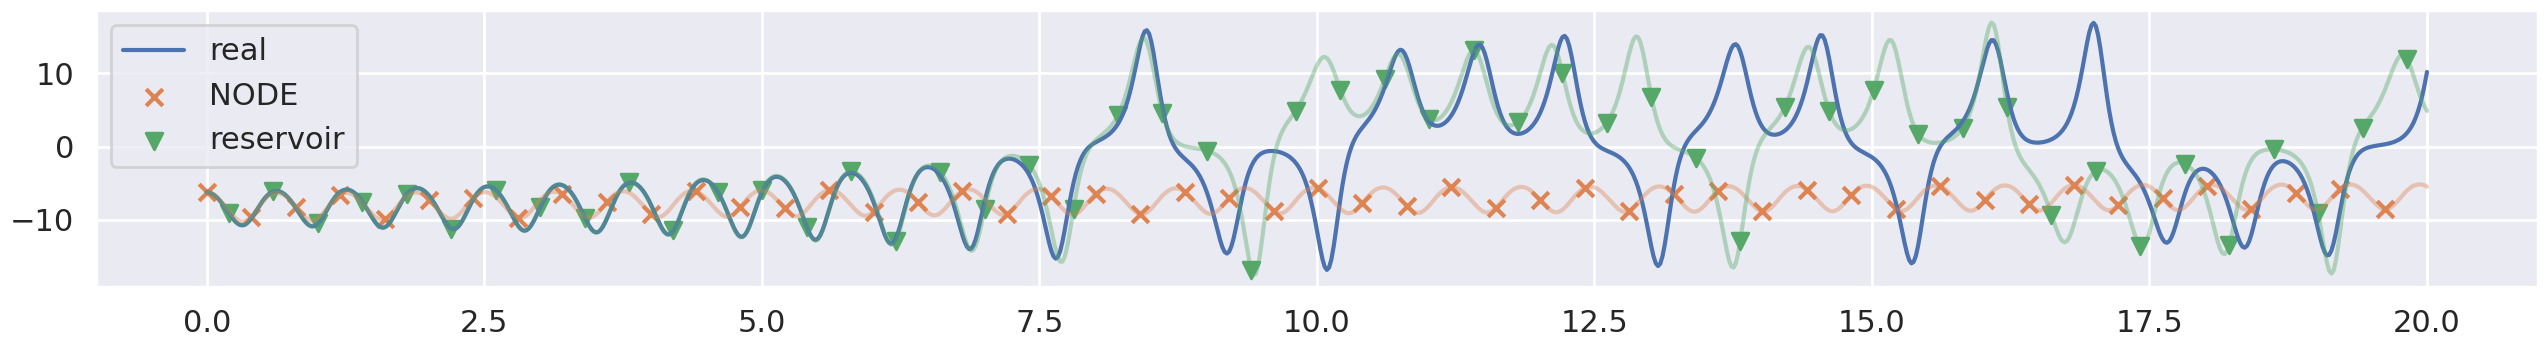

In [35]:
func = torch.load("best_NODE.pt")


X_val = torch.tensor(X_val, dtype=torch.float)
starting_point = X_val[0,:]
I = torch.linspace(0,20,int(20/dt))
y_pred = odeint(func, starting_point, I, method=METHOD).detach().numpy()

predicted_time_node = max_predicted_time(X_val, y_pred,dt=dt)
print(f"NODE max time:{predicted_time_node}")
predicted_time_res = max_predicted_time(X_val, X_res,dt=dt)
print(f"RES. max time:{predicted_time_res}")

for dim in range(3):
      plt.figure(figsize=(26, 4))

      mask = np.arange(0,len(I)) % 20 == 0
      mask_2 = (np.arange(0,len(I))+10) % 20 == 0

      plt.plot(I, X_val[:,dim],  color='C0', label='real')
      plt.scatter(I[mask], y_pred[:,dim][mask],  color='C1', label='NODE', marker="x")
      plt.plot(I, y_pred[:,dim],  color='C1',  alpha=0.4)

      plt.scatter(I[mask_2], X_res[:,dim][mask_2],  color='C2', label='reservoir', marker='v')
      plt.plot(I, X_res[:,dim],  color='C2', alpha=0.4)


      #plt.plot(predicted_time*np.ones(2), [y_pred[:,dim].min(),y_pred[:,dim].max()],'k--', label="divergence time")

      plt.legend()
      plt.tight_layout()
      plt.savefig('Lorenz_1.png',dpi=600)
      plt.show()
      break


In [ ]:
func = torch.load('best_NODE.pt')

AttributeError: 'Axes3D' object has no attribute 'tight_layout'

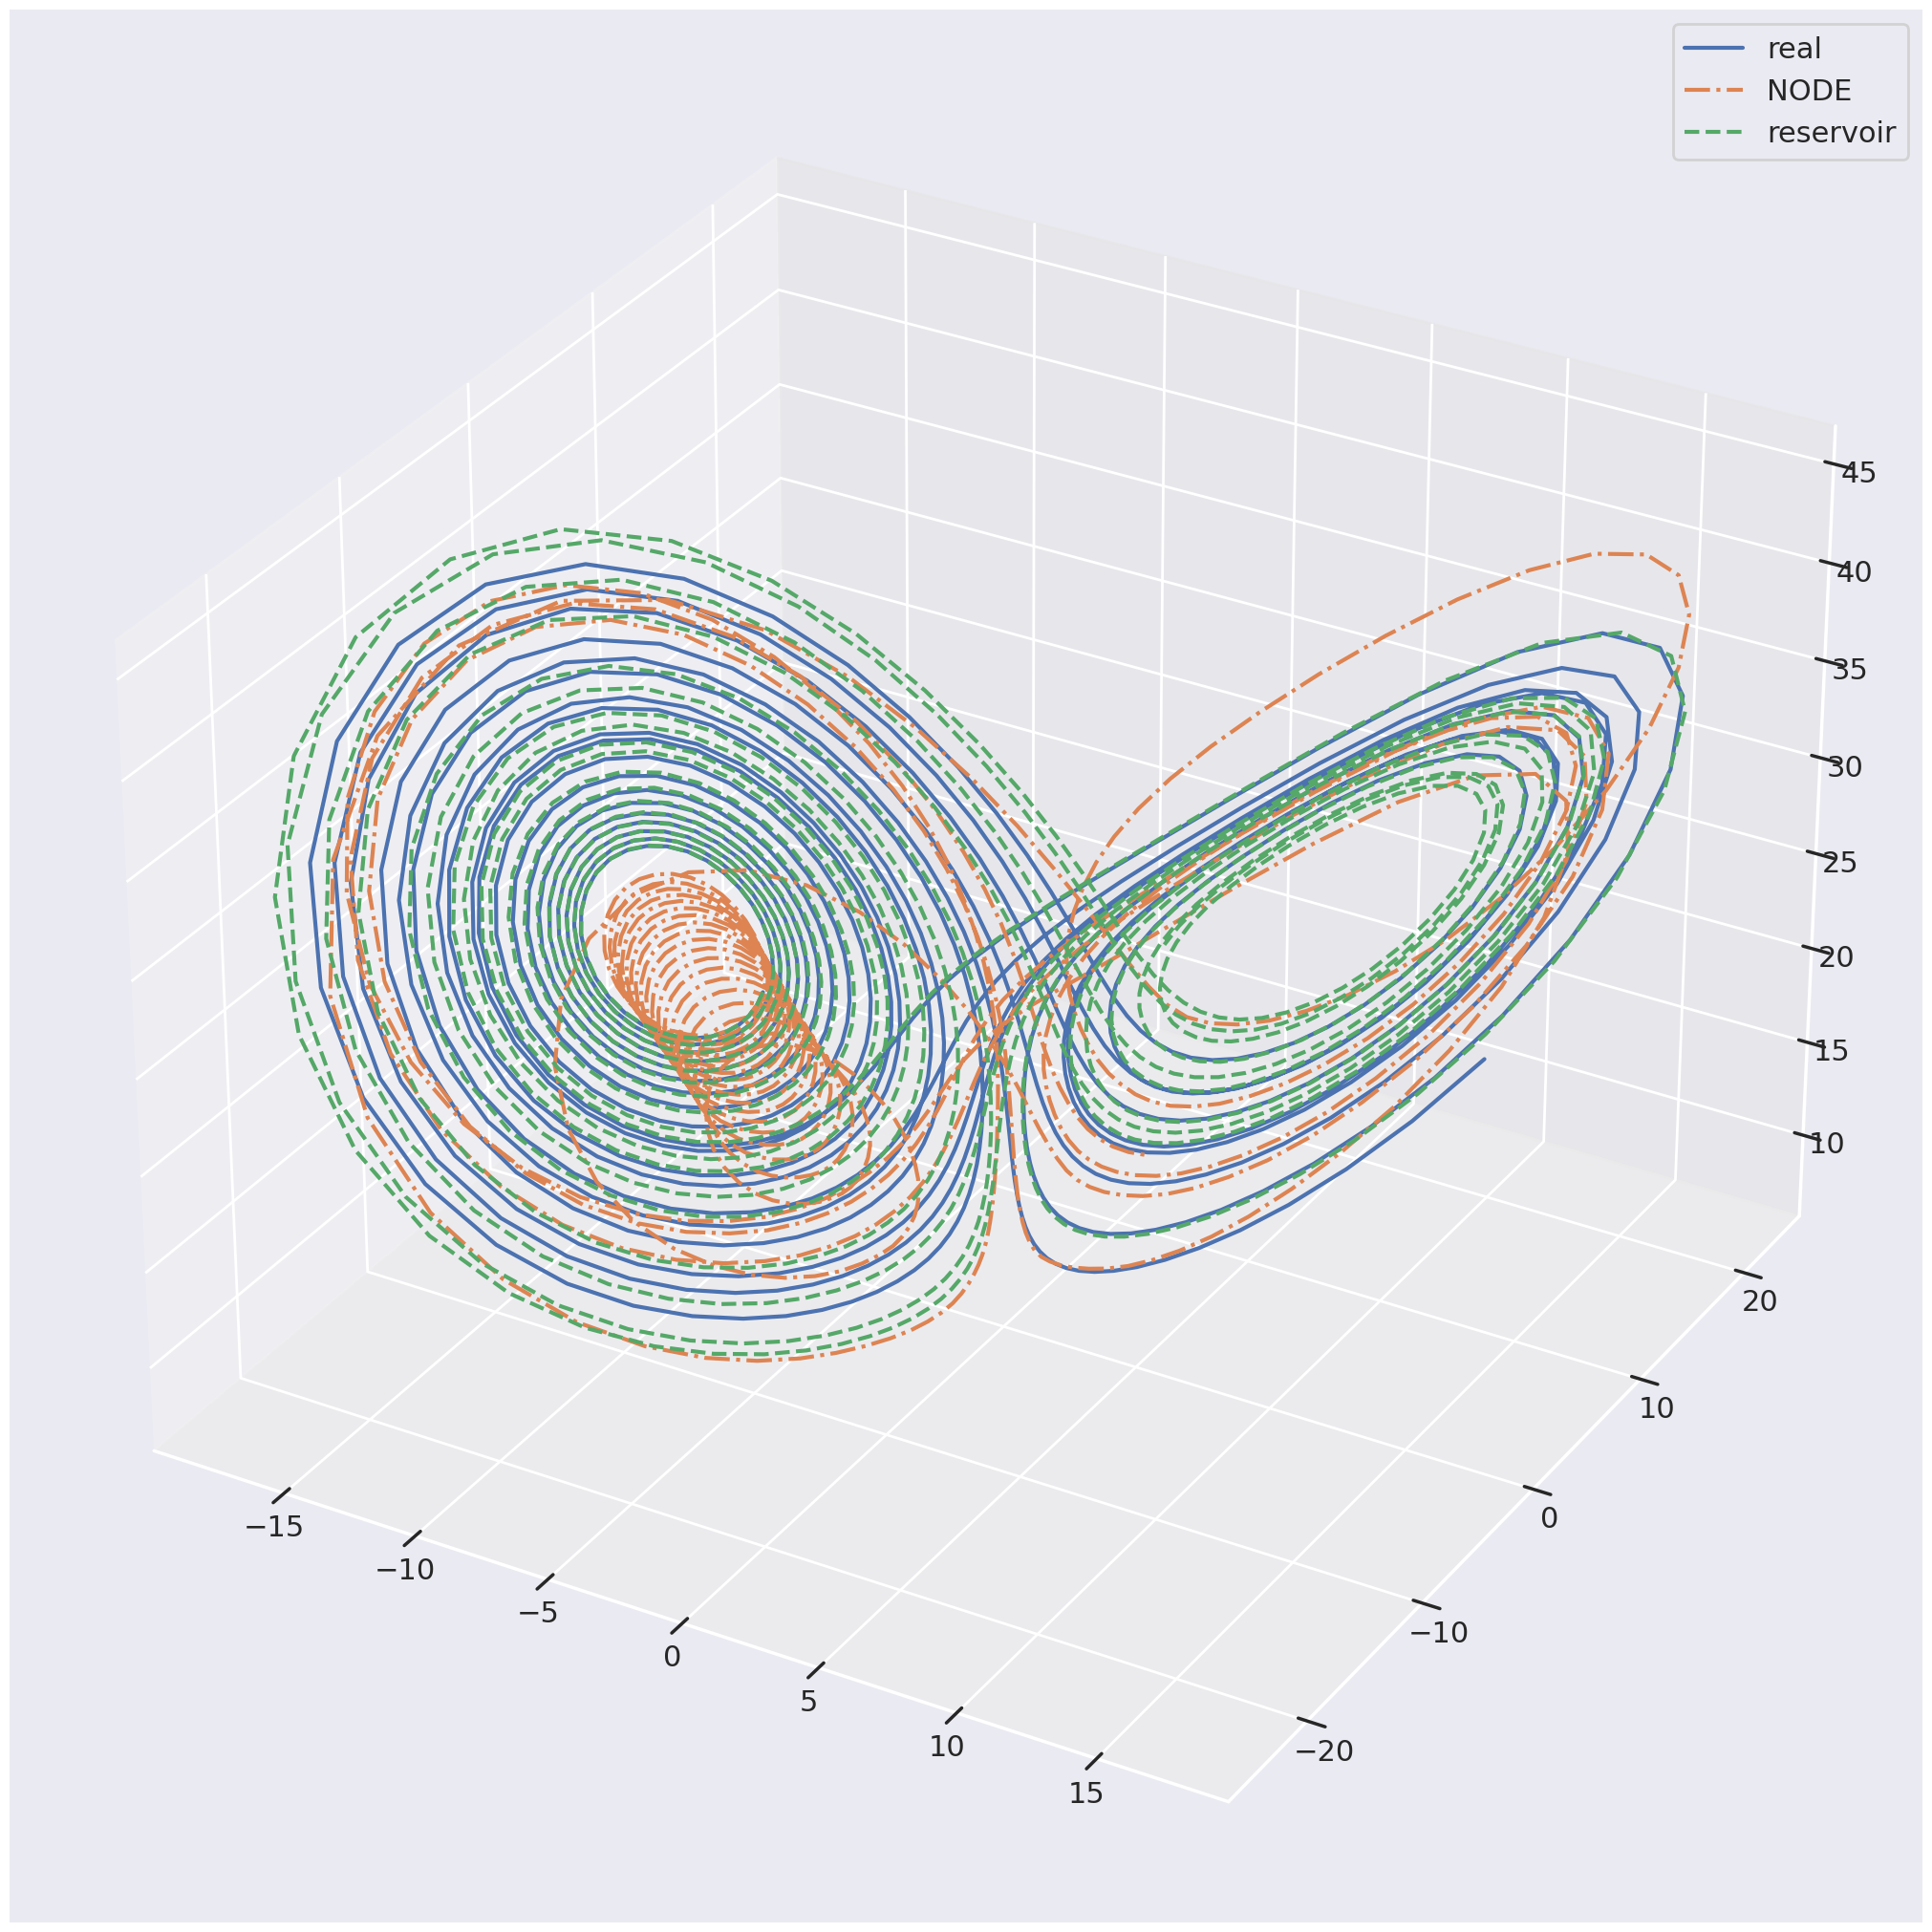

In [ ]:
plt.figure(figsize=(26,26))
ax = plt.axes(projection='3d')
ax.plot3D(X_val[:,0], X_val[:, 1], X_val[:, 2],color="C0", label='real')
ax.plot3D(y_pred[:,0], y_pred[:, 1], y_pred[:, 2],color="C1", linestyle='-.', label='NODE')
ax.plot3D(X_res[:,0], X_res[:, 1], X_res[:, 2],color="C2", linestyle='--', label='reservoir')

plt.legend()
plt.tight_layout()

plt.savefig('Lorenz_3D.png',dpi=600)
plt.show()
